#### License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"> CC BY Creative Commons License</a>, with the exception of the data (a seismic section from the [F3 open 3D survey](https://terranubis.com/datainfo/Netherlands-Offshore-F3-Block-Complete) which is covered by a [CC BY-SA Creative Commons License](https://creativecommons.org/licenses/by-sa/3.0/).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm as cm
import skimage.color as skl
from skimage import io
from ipywidgets import interact, interactive, FloatSlider

In [2]:
from matplotlib import rc
font = {'size'   : 16}
rc('font', **font)

In [3]:
data_folder = "./data"

In [4]:
data=np.load(os.path.join(data_folder,'F3_dip_steered_med_IL230-43_XL475-675_T1660.npy'))

In [5]:
def expo(x,a):
    """
    Makes an exponential curve.  
    
    Parameter:
        x (array): the x coordinate
        a (int): compressiveness
        
    Returns:
        y (array): the 1D exponential curve
    """
    y = np.array(1-(np.exp(1-(a*x))/2.5))
    return 100.0*(y-min(y))/(max(y)-min(y)) 

def rgb_expo(y):
    """ 
    Makes an RGB array of size 256x256, which can then be plotted as rectuangular colorbar image
    (with a specific plt.imshow aspect ratio)
    
    Parameters:
        y (array): exponential 1D curve. Can be output of expo function. 
        It is used as Lightness (L) dimension of initial Lab array
    
    Returns:
        rgb_exponential (array): the 256x256 RGB array
    """
    lexp = np.tile(y, (256,1))
    aexp = np.zeros((256,256))
    bexp = np.zeros((256,256))
    lab_exp = np.array(list(zip(lexp, aexp, bexp)))
    lab_exponential = np.swapaxes(lab_exp,1,2)
    rgb_exponential = skl.lab2rgb(lab_exponential)
    return rgb_exponential

def rgb_cmap(rgb_exponential):
    """ 
    Makes a Matplotlib LinearSegmentedColormap RGB exponential grayscale
    
    Parameters:
        rgb_exponential (array): exponential RGB array. Can be output of rgb_expo function   
    
    Returns:
        my_exp_cmap: LinearSegmentedColormap
    """
    r_exp = rgb_exponential[0,:,0]
    g_exp = rgb_exponential[0,:,1]
    b_exp = rgb_exponential[0,:,2]

    # sample 256 not perfectly 1. Normalizing y to [0-1]
    normr_exp=(r_exp-min(r_exp))/(max(r_exp)-min(r_exp))
    normg_exp=(g_exp-min(g_exp))/(max(g_exp)-min(g_exp))
    normb_exp=(b_exp-min(b_exp))/(max(b_exp)-min(b_exp))
    
    b3=normb_exp # value of blue at sample n
    b2=normb_exp # value of blue at sample n
    b1=np.linspace(0,1,len(b2)) # position of sample n - ranges from 0 to 1
    g3=normg_exp 
    g2=normg_exp
    g1=np.linspace(0,1,len(g2))
    r3=normr_exp 
    r2=normr_exp
    r1=np.linspace(0,1,len(r2))
    r=zip(r1,r2,r3) # red list
    g=zip(g1,g2,g3) # green list
    b=zip(b1,b2,b3) # blue list
    rgb_=zip(r,g,b) # creating final list
    rgb=zip(*rgb_)  # transposing list
    k=['red', 'green', 'blue'] # keys
    exponential_gray=dict(zip(k,rgb))  # makes a dictionary for LinearSegmentedColormap
    my_exp_cmap = clr.LinearSegmentedColormap('my_colormap', exponential_gray)
    return my_exp_cmap

def find_50_idx(y):
    """
    Find the index of first element in a 1D array of value > 50.
    In other words, the sample number corresponding to the 50% Lightness point in the colormap.
    """
    idx = np.searchsorted(y, 50, side="right").astype(int)
    return idx

In [6]:
def exponential_demo(e): 
    ### Setting up variables for exponential L colormap
    x = np.arange(256)
    y = expo(x, e)
    rgb_exponential = rgb_expo(y)
    my_exp_cmap = rgb_cmap(rgb_exponential)
    
    ### Setting up variables for plain gray L colormap
    bw1=cm.gray(np.arange(256))
    bw=bw1[:,:-1] # slicing to remove alpha
    rbw = np.tile(bw[:,0], (256,1))
    gbw = np.tile(bw[:,1], (256,1))
    bbw = np.tile(bw[:,2], (256,1))
    rgb_bw=np.swapaxes(np.array(list(zip(rbw, gbw, bbw))),1,2)
    lab_bw = skl.rgb2lab(rgb_bw)
    l_bw = lab_bw[0,:,0]

    ### Setting up figure
    idx = find_50_idx(y)
    y_ticks=[0, 20, 40, 50, 60, 80, 100]
    x_ticks = [0, 50, 100, 150, 200, 250]
    x_ticks.append(idx)
    x_ticks=sorted(x_ticks)
    
    idx1 = find_50_idx(l_bw) 
    y_ticks1=[0, 20, 40, 50, 60, 80, 100]
    x_ticks1 = [0, 50, 100, 150, 200, 250]
    x_ticks1.append(idx1)
    x_ticks1=sorted(x_ticks1)
    
    ########
    
    
    fig = plt.figure(figsize=(18,22))
    
    # Interactive textbox plot of exponent value
    ax3 = plt.subplot2grid((6,2), (0,0), colspan=1, rowspan = 1)
    ax3.set_axis_off()
    bbox_props = dict(boxstyle="square, pad=0.5", fc="white", ec="0.5")
    ax3.text(0.1, 0.1, 'Exponent = {0:.3f}'.format(e), ha="center", 
                 va="center", size=18, bbox=bbox_props)

    ### Interactive exponential gray Lightness profile display
    ax1 = plt.subplot2grid((6,2), (1,0),colspan=1, rowspan = 1)
    ax1.scatter(x,y, s = 100, c = my_exp_cmap(x))
    ax1.set_yticks([50], minor=True)
    ax1.set_yticks([0, 25, 50, 75, 100])
    ax1.set_yticklabels([0, 25, 50, 75, 100])
    ax1.set_xticks([idx], minor=True)
    locx = list(ax1.xaxis.get_ticklocs())
    locx.append(idx)
    ax1.set_xticks(locx)
    ax1.set_xlim(min(x),max(x))
    ax1.axhline(50, linestyle='--', color='k') 
    ax1.axvline(idx, linestyle='--', color='k')
    ax1.set_title('Lightness profile for the exponential grayscale')

    ### Interactive exponential gray colormap display
    ax2 =  plt.subplot2grid((6,2), (2,0),colspan=1, rowspan = 1)
    ax2.imshow(rgb_exponential, interpolation = 'none', aspect='auto')
    ax2.plot([idx,idx], [0,255], '--k')
    ax2.set_xticks(x_ticks);
    ax2.tick_params(axis='y', color='w', labelcolor='white')
    ax2.set_title('Grayscale plot for the exponential grayscale')

    ### Interactive seismic time slice displayed with exponential gray
    ax3 =  plt.subplot2grid((6,2), (3,0),colspan=1, rowspan = 2)
    ax3.imshow(data, cmap = my_exp_cmap, interpolation = 'none', aspect='auto')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Seismic time slice with exponential grayscale')
    
    ### Interactive standard gray Lightness profile display
    ax4 = plt.subplot2grid((6,2), (1,1),colspan=1, rowspan = 1)
    ax4.scatter(x,l_bw, s = 100, c = my_exp_cmap(x))
    ax4.set_yticks([50], minor=True)
    ax4.set_yticks([0, 25, 50, 75, 100])
    ax4.set_yticklabels([0, 25, 50, 75, 100])
    ax4.set_xticks([idx1], minor=True)
    locx1 = list(ax4.xaxis.get_ticklocs())
    locx1.append(idx1)
    ax4.set_xticks(locx1)
    ax4.set_xlim(min(x),max(x))
    ax4.axhline(50, linestyle='--', color='k') 
    ax4.axvline(idx1, linestyle='--', color='k')
    ax4.set_title('Lightness profile for the standard grayscale')

    ### Interactive conventional gray colormap display
    ax5 =  plt.subplot2grid((6,2), (2,1),colspan=1, rowspan = 1)
    ax5.imshow(rgb_bw, interpolation = 'none', aspect='auto')
    ax5.plot([idx1,idx1], [0,255], '--k')
    ax5.set_xticks(x_ticks1);
    ax5.tick_params(axis='y', color='w', labelcolor='white')
    ax5.set_title('Grayscale plot for the standard grayscale')

    ### Interactive seismic time slice displayed with conventional gray
    ax6 =  plt.subplot2grid((6,2), (3,1),colspan=1, rowspan = 2)
    ax6.imshow(data, cmap = 'gray', interpolation = 'none', aspect='auto')
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax6.set_title('Seismic time slice with standard grayscale')

    plt.tight_layout();

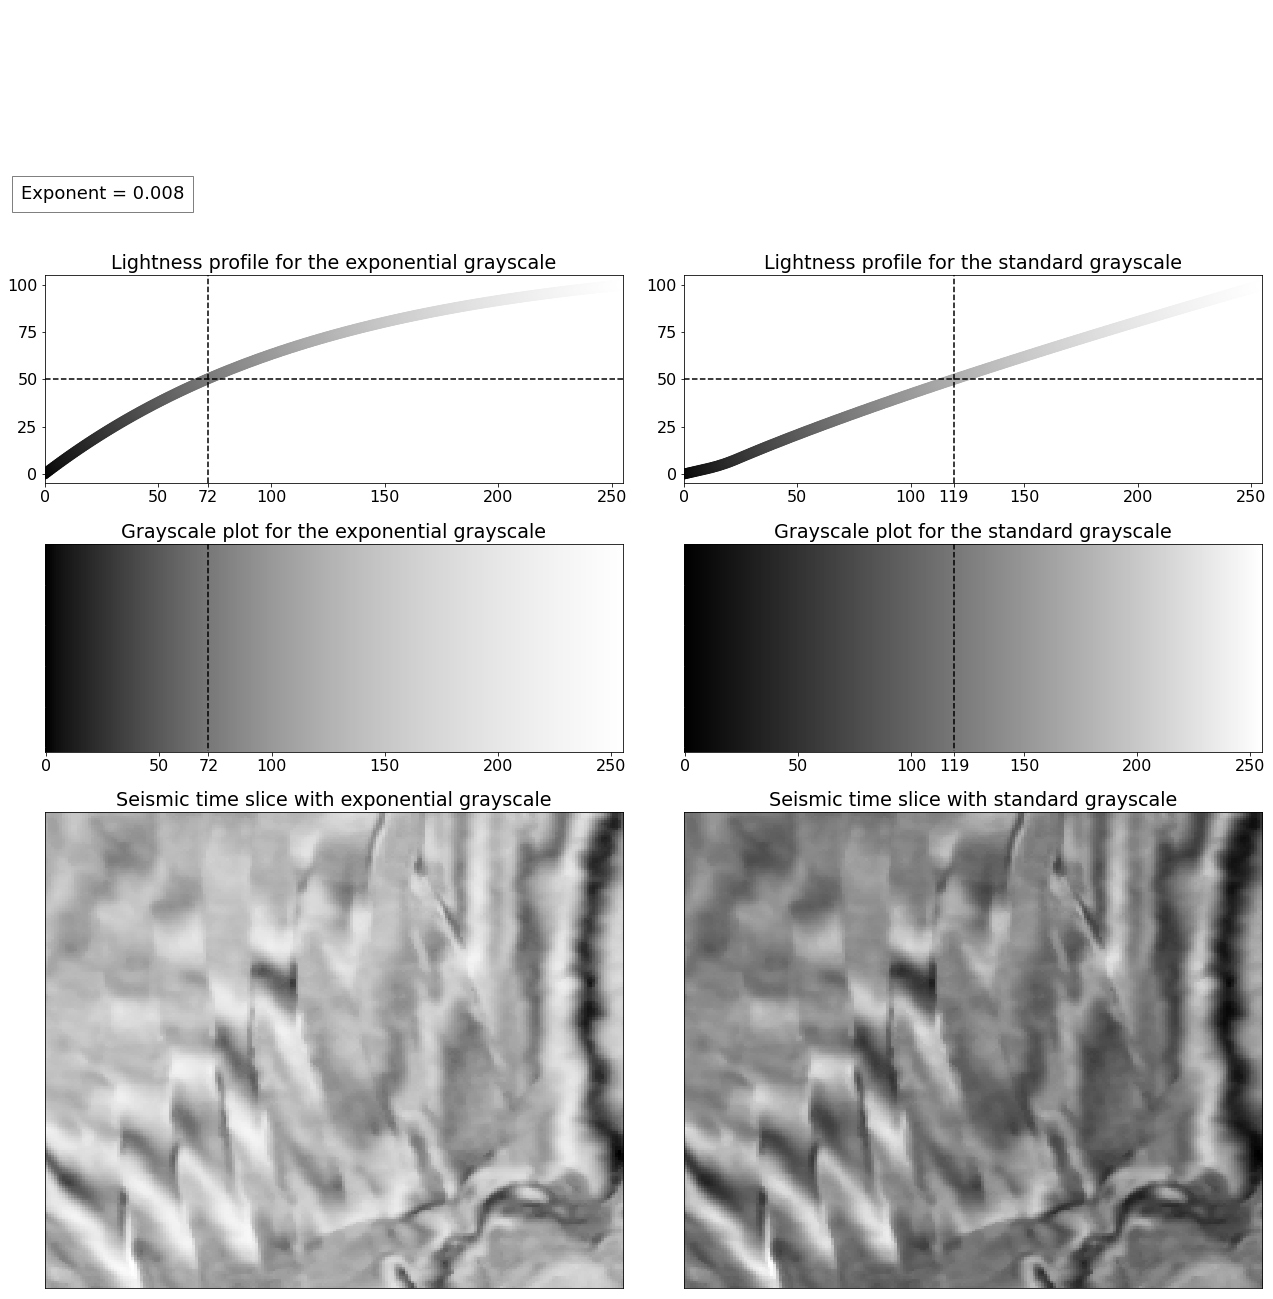

In [7]:
interact(exponential_demo, e=FloatSlider(min=0.002, max = 0.02, step=0.002, value=0.008));